# Identifying Best EMAs and Suggesting Trades

In [ ]:
import os
from IPython.display import Image
Image("Pic3.png",width=900, height=700)

: 

# Trading Strategy:
1.	Identify BTC’s trend (Positive or Negative Positions)
2.	Identify BTC’s best performing EMA
3.	Identify the best COIN to trade in relation to BTC (Correlation/Sensitivity)
4.	Apply the best performing EMA to the target COIN
5.	Suggest trades on the target COIN


## Agenda:
1. Loading the Data
2. Running Regression
3. Plotting Regression
4. Calculating Velocity
5. Calculating Bounce Rate Efficiency
6. Finding the best EMA
7. Calculating the Correlations between BTC and Other Coins
8. Suggesting Trades
9. Plotting Suggested Trades
10. Backtesting
11. Streamlit App

## 1. Loading the data

In [ ]:
!pip install streamlit
!pip install ccxt
!pip install python-binance

import streamlit as st
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from datetime import datetime, timedelta
from binance.client import Client
from sklearn.linear_model import LinearRegression
from PIL import Image

# Set your Binance API credentials
#API_KEY = 'y81iTWnTzk167qwa2JOi3500nP1qt04t099UYnzrON9yXv827alvnxkAhcUryOII'
#API_SECRET = 'jMo05jKg4GDKmkxqRGSDnGTji5KJ1D9i7OWTLt9WdJcHT0Q91V95wUHaQbQ80yeq'
API_KEY = 'L20wkbLFpCUb073Idp77gPFHVIQCvZMwWqCgr2gUI5TmKMB4KJawLm6XrsI2doLG'
API_SECRET = 'RJxUalW7TEZRQvlfAyLAzGDg2iWs8r5ArJVEzyF7GM8IvLhLttFos8AkOGBhSDTp'

# Initialize Binance client
client = Client(API_KEY, API_SECRET, {"timeout": 2})

def fetch_crypto_data(symbol, interval, days=3):
    """Fetch historical data for a given symbol and interval."""
    since = int((datetime.now() - timedelta(days=days)).timestamp() * 1000)
    candles = client.get_klines(symbol=symbol, interval=interval, startTime=since)
    df = pd.DataFrame(candles, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
    df = df[['timestamp', 'open', 'high', 'low', 'close', 'volume']]
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].astype(float)
    return df


: 

In [33]:
btc_df = fetch_crypto_data('BTCUSDT', "15m", days = 2)
btc_df

,timestamp,open,high,low,close,volume
0,2025-06-01 07:30:00,104341.47,104349.06,104222.90,104243.07,53.96851
1,2025-06-01 07:45:00,104243.07,104296.93,104229.61,104275.95,48.71399
2,2025-06-01 08:00:00,104275.95,104310.82,104220.70,104262.05,79.21267
3,2025-06-01 08:15:00,104262.47,104333.34,104240.00,104291.42,70.27044
4,2025-06-01 08:30:00,104291.42,104341.47,104261.82,104341.46,41.06270
...,...,...,...,...,...,...
187,2025-06-03 06:15:00,105367.43,105390.76,105247.84,105247.84,85.38006
188,2025-06-03 06:30:00,105247.85,105285.72,105218.00,105248.74,122.77435
189,2025-06-03 06:45:00,105248.73,105441.16,105248.73,105429.67,200.26228
190,2025-06-03 07:00:00,105429.67,105438.02,105381.71,105382.15,107.02106


## 2. Running Regression

In [34]:
def calculate_regression(df):
    """Calculate regression analysis to determine trend."""
    X = np.arange(len(df)).reshape(-1, 1)
    y = df['close'].values
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    slope = model.coef_[0]
    return 'Positive' if slope > 0 else 'Negative' if slope < 0 else 'Flat', y_pred

In [35]:
btc_trend, y_pred = calculate_regression(btc_df)
btc_trend

'Positive'

## 3. Plotting Regression

In [36]:
def plot_regression(df, y_pred, height=500):
    """Plot regression analysis."""
    plt.figure(figsize=(12, height / 100))
    plt.plot(df['timestamp'], df['close'], label='BTC Price', color='blue')
    plt.plot(df['timestamp'], y_pred, label='Regression Line', color='red', linestyle='--')
    plt.title('BTC Price with Regression Line')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    st.pyplot(plt)

2025-06-03 07:19:50.555 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-03 07:19:51.126 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-03 07:19:51.127 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


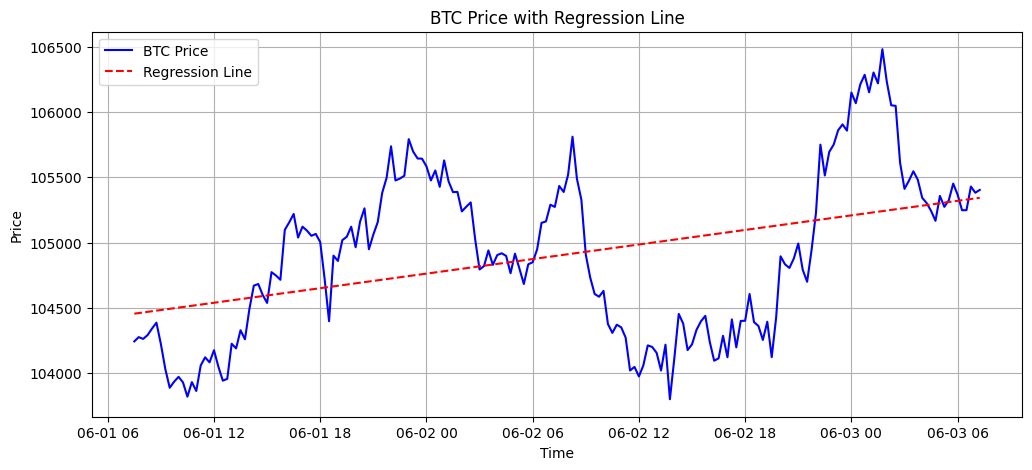

In [37]:
%matplotlib inline
plot_regression(btc_df, y_pred)

## 4. Calculating Velocity

##### Function Purpose:
To measure how strongly the price reacts (up or down) after crossing or touching an Exponential Moving Average (EMA). The velocity is computed based on the price movement over a specified number of periods (k) following each touch

- A "touch" occurs when the price crosses the EMA from either direction (above or below):
- df['close'].shift(1) > df[ema_col] and df['close'] <= df[ema_col]: Price moves from above the EMA to below.
- df['close'].shift(1) < df[ema_col] and df['close'] >= df[ema_col]: Price moves from below the EMA to above.
- The condition uses bitwise & (AND) and | (OR) to combine the criteria.
- The shift(1) ensures the comparison is done between consecutive rows (i.e., price crosses the EMA between two time steps).

##### For each index where a touch occurs:
- Ensure there are at least k periods remaining in the DataFrame (to avoid out-of-bounds errors).
- Calculate the absolute price reaction:
abs(df.loc[idx + k, 'close'] - df.loc[idx, 'close']): Measures the price change between the closing price k periods after the touch and the closing price at the touch.
- Append this reaction value to the velocities list.

In [38]:
def calculate_price_reaction_velocity(df, ema_col, k=5):
    """Calculate Price Reaction Velocity."""
    touches = df[(df['close'].shift(1) > df[ema_col]) & (df['close'] <= df[ema_col]) | 
                 (df['close'].shift(1) < df[ema_col]) & (df['close'] >= df[ema_col])]
    velocities = []
    for idx in touches.index:
        if idx + k < len(df):
            reaction = abs(df.loc[idx + k, 'close'] - df.loc[idx, 'close'])
            velocities.append(reaction)
    return np.mean(velocities) if velocities else 0

## 5. Calculating Bounce Rate Efficiency

- The function calculate_bounce_efficiency calculates the efficiency of price bounces after the price of an asset "touches" an Exponential Moving Average (EMA). It measures the proportion of significant bounces (price reactions exceeding a threshold) relative to all touches of the EMA.

##### Function Purpose:
To evaluate how often the price makes a significant bounce after crossing or touching the EMA.

###### Input Parameters:
- df: A DataFrame containing price data (must include 'close' and the specified EMA column).
- ema_col: The name of the column containing the EMA values.
- k: Number of periods after a touch to evaluate the bounce. Default is 5.
- threshold: The minimum percentage change in price considered a significant bounce. Default is 0.01 (1%).

###### For each touch (index where the price crosses the EMA):
- Ensure there are at least k periods remaining to avoid out-of-bounds errors.
- Calculate the absolute price reaction:
- reaction = abs(df.loc[idx + k, 'close'] - df.loc[idx, 'close'])
- This measures the price change k periods after the touch.
- Check if the reaction exceeds the significance threshold:
- reaction > threshold * df.loc[idx, 'close']
- Compares the reaction to a percentage (threshold) of the price at the touch.
- If significant, increment the significant_bounces counter.

In [39]:
def calculate_bounce_efficiency(df, ema_col, k=5, threshold=0.01):
    """Calculate Bounce Efficiency."""
    touches = df[(df['close'].shift(1) > df[ema_col]) & (df['close'] <= df[ema_col]) | 
                 (df['close'].shift(1) < df[ema_col]) & (df['close'] >= df[ema_col])]
    significant_bounces = 0
    for idx in touches.index:
        if idx + k < len(df):
            reaction = abs(df.loc[idx + k, 'close'] - df.loc[idx, 'close'])
            if reaction > threshold * df.loc[idx, 'close']:
                significant_bounces += 1
    return significant_bounces / len(touches) if len(touches) > 0 else 0  

## 6. Finding the best EMA

###### Function Purpose
- The function identifies the best-performing Exponential Moving Average (EMA) for a given dataset based on two metrics:
    - Price Reaction Velocity: Measures how strongly the price reacts after touching the EMA.
    - Bounce Efficiency: Evaluates how often the price makes significant bounces after touching the EMA.
- It also generates and displays individual candlestick charts for each EMA in the specified range.

In [40]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

def identify_best_ma_ema_and_plot(df):
    """
    Identify the best performing MA or EMA using weighted velocity, efficiency, and combined score.
    Plot individual candlestick charts for BTC price with each EMA.
    """
    results = []

    # Loop through EMA periods in the specified range
    for period in range(15, 91, 2):
        # Calculate EMA
        df[f'EMA_{period}'] = df['close'].ewm(span=period, adjust=False).mean()

        # Calculate metrics
        velocity = calculate_price_reaction_velocity(df, f'EMA_{period}')
        efficiency = calculate_bounce_efficiency(df, f'EMA_{period}')
        
        # Handle missing or invalid values for velocity/efficiency
        if velocity is None or efficiency is None:
            velocity = 0
            efficiency = 0

        results.append({
            'Period': period,
            'Metric': f'EMA_{period}',
            'Velocity': velocity,
            'Efficiency': efficiency,
        })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    # Scale velocity and efficiency between 0 and 1
    results_df['Scaled Velocity'] = (results_df['Velocity'] - results_df['Velocity'].min()) / \
                                    (results_df['Velocity'].max() - results_df['Velocity'].min())
    results_df['Scaled Efficiency'] = (results_df['Efficiency'] - results_df['Efficiency'].min()) / \
                                       (results_df['Efficiency'].max() - results_df['Efficiency'].min())

    #results_df['Scaled Efficiency'] = results_df['Scaled Efficiency'].fillna(0)
    
    # Calculate the combined score with weights: 41% velocity, 59% efficiency
    results_df['Combined Score'] = 0.41 * results_df['Scaled Velocity'] + 0.59 * results_df['Scaled Efficiency'].fillna(0)

    # Identify the best EMA based on the highest combined score
    best = results_df.sort_values('Combined Score', ascending=False).iloc[0]

    # Plot individual candlestick charts for each EMA
    for period in range(15, 91, 2):
        # Create a new figure for this EMA
        fig = go.Figure()

        # Add candlestick data
        fig.add_trace(go.Candlestick(
            x=df.index,
            open=df['open'],
            high=df['high'],
            low=df['low'],
            close=df['close'],
            name='BTC Price'
        ))

        # Add the specific EMA line
        fig.add_trace(go.Scatter(
            x=df.index,
            y=df[f'EMA_{period}'],
            mode='lines',
            name=f'EMA_{period}'
        ))

        # Customize layout for the chart
        fig.update_layout(
            title=f'BTC Price with EMA {period}',
            xaxis_title='Date',
            yaxis_title='Price (BTC)',
            legend_title='Legend',
            template='plotly_dark',
            xaxis_rangeslider_visible=False
        )

        # Display the chart for this EMA
        fig.show()

    return best['Metric'], results_df

In [41]:
# results = identify_best_ma_ema_and_plot(btc_df)
best_metric, all_metrics_df = identify_best_ma_ema_and_plot(btc_df)

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.11/dist-packages/pan

In [42]:
all_metrics_df

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning:

invalid value encountered in greater



,Period,Metric,Velocity,Efficiency,Scaled Velocity,Scaled Efficiency,Combined Score
0,15,EMA_15,297.505333,0.0,0.864563,NaN,0.354471
1,17,EMA_17,293.299333,0.0,0.824595,NaN,0.338084
2,19,EMA_19,286.397407,0.0,0.759007,NaN,0.311193
3,21,EMA_21,271.560000,0.0,0.618011,NaN,0.253385
4,23,EMA_23,274.157308,0.0,0.642693,NaN,0.263504
5,25,EMA_25,271.815000,0.0,0.620434,NaN,0.254378
6,27,EMA_27,278.363333,0.0,0.682662,NaN,0.279891
7,29,EMA_29,286.992917,0.0,0.764666,NaN,0.313513
8,31,EMA_31,301.431200,0.0,0.901870,NaN,0.369767
9,33,EMA_33,311.757727,0.0,1.000000,NaN,0.410000


## 7. Calculating the Correlations between BTC and Other Coins

In [43]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np

def calculate_correlation_and_sensitivity(base_df, target_df, decimals=4):
    """
    Calculate correlation, sensitivity, and trend direction score between base and target dataframes,
    based on percentage changes in 'close' prices, and compute the weighted combined score.

    Parameters:
        base_df (pd.DataFrame): The base dataframe with a 'close' column.
        target_df (pd.DataFrame): The target dataframe with a 'close' column.
        decimals (int): Number of decimal places for formatting. Default is 4.

    Returns:
        float, float, float, float: Correlation, sensitivity (beta coefficient), trend direction score, and weighted combined score.
    """
    # Calculate percentage changes
    base_pct_change = base_df['close'].pct_change().dropna()
    target_pct_change = target_df['close'].pct_change().dropna()

    # Align indices
    aligned_data = pd.concat([base_pct_change, target_pct_change], axis=1).dropna()
    aligned_data.columns = ['Base_pct_change', 'Target_pct_change']

    # Calculate correlation coefficient
    correlation = aligned_data.corr().iloc[0, 1]

    # Regression for sensitivity (beta coefficient)
    X = aligned_data['Base_pct_change'].values.reshape(-1, 1)
    y = aligned_data['Target_pct_change'].values
    reg = LinearRegression()
    reg.fit(X, y)
    sensitivity = reg.coef_[0]

    # Regression for trend direction score
    indices = np.arange(len(target_df['close'])).reshape(-1, 1)  # Use index as a proxy for time
    target_close = target_df['close'].values
    trend_reg = LinearRegression()
    trend_reg.fit(indices, target_close)
    trend_direction_score = trend_reg.coef_[0]  # Slope of the trend line

    # Scale correlation, sensitivity, and trend direction score to 0-1
    correlation_scaled = (correlation + 1) / 2  # Assuming correlation is in [-1, 1]
    sensitivity_scaled = sensitivity / (abs(sensitivity) + 1)  # Normalize sensitivity for scaling
    trend_direction_scaled = (trend_direction_score - min(trend_direction_score, 0)) / \
                              (max(trend_direction_score, 0) + abs(min(trend_direction_score, 0)))

    # Weighted combined score
    combined_score = (
        0.31 * correlation_scaled +
        0.32 * sensitivity_scaled +
        0.37 * trend_direction_scaled
    )

    # Format results to fixed decimals
    correlation = round(correlation, decimals)
    sensitivity = round(sensitivity, decimals)
    trend_direction_score = round(trend_direction_score, decimals)
    combined_score = round(combined_score, decimals)

    return correlation, sensitivity, trend_direction_score, combined_score

In [45]:
# Daftar koin
coins = ['USDTTRY', 'USDTARS', 'USDTCOP', 'BTCUSDT', 'ETHUSDT', 'DOGEUSDT',
         'USDCUSDT', 'SUIUSDT', 'SOLUSDT', 'XRPUSDT', 'FDUSDUSDT',
         'BIOUSDT', 'PEPEUSDT', 'ADAUSDT', 'ENAUSDT', 'TRXUSDT', 'XLMUSDT',
         'FDUSDTRY', 'BNBUSDT', 'PENGUUSDT', 'HBARUSDT', 'USDTBRL',
         'USUALUSDT', 'PHAUSDT', 'PNUTUSDT', 'LINKUSDT', 'NEIROUSDT',
         'ARBUSDT', 'SHIBUSDT', 'AVAXUSDT', 'WLDUSDT', 'BONKUSDT',
         'MOVEUSDT', 'AAVEUSDT', 'RSRUSDT', 'WIFUSDT', 'SUSHIUSDT',
         'UNIUSDT', 'LTCUSDT', 'STGUSDT', 'TAOUSDT', 'FLOKIUSDT', 'FTMUSDT',
         'GALAUSDT', 'TROYUSDT', 'CRVUSDT', 'ACTUSDT', 'DOTUSDT',
         'SANDUSDT', 'ZENUSDT']

results = []

for coin in coins:
    print(f"🔍 Memproses {coin}...")

    # Ambil data target
    target_df = fetch_crypto_data(coin, '15m', days=2)
    # Ambil data basis (BTCUSDT)
    base_df = fetch_crypto_data('BTCUSDT', '15m', days=2)

    # Pastikan data tidak kosong
    if target_df.empty or base_df.empty:
        print(f"⚠️  Data kosong untuk {coin}. Lewati.")
        results.append({'Coin': coin, 'Correlation': 0, 'Sensitivity': 0, 'trend_direction_score': 0, 'Combined Score': 0})
        continue

    # Hitung korelasi, sensitivitas, dst.
    correlation, sensitivity, trend_direction_score, combined_score = calculate_correlation_and_sensitivity(base_df, target_df, 4)

    # Simpan hasil
    results.append({
        'Coin': coin,
        'Correlation': correlation,
        'Sensitivity': sensitivity,
        'trend_direction_score': trend_direction_score,
        'Combined Score': combined_score
    })

# Buat DataFrame hasil
results_df = pd.DataFrame(results)
print("\n✅ Semua koin selesai diproses!")
print(results_df)


🔍 Memproses USDTTRY...
🔍 Memproses USDTARS...
🔍 Memproses USDTCOP...
🔍 Memproses BTCUSDT...
🔍 Memproses ETHUSDT...
🔍 Memproses DOGEUSDT...
🔍 Memproses USDCUSDT...
🔍 Memproses SUIUSDT...
🔍 Memproses SOLUSDT...
🔍 Memproses XRPUSDT...
🔍 Memproses FDUSDUSDT...
🔍 Memproses BIOUSDT...
🔍 Memproses PEPEUSDT...
🔍 Memproses ADAUSDT...
🔍 Memproses ENAUSDT...
🔍 Memproses TRXUSDT...
🔍 Memproses XLMUSDT...
🔍 Memproses FDUSDTRY...
🔍 Memproses BNBUSDT...
🔍 Memproses PENGUUSDT...
🔍 Memproses HBARUSDT...
🔍 Memproses USDTBRL...
🔍 Memproses USUALUSDT...
🔍 Memproses PHAUSDT...
🔍 Memproses PNUTUSDT...
🔍 Memproses LINKUSDT...
🔍 Memproses NEIROUSDT...
🔍 Memproses ARBUSDT...
🔍 Memproses SHIBUSDT...
🔍 Memproses AVAXUSDT...
🔍 Memproses WLDUSDT...
🔍 Memproses BONKUSDT...
🔍 Memproses MOVEUSDT...
🔍 Memproses AAVEUSDT...
🔍 Memproses RSRUSDT...
🔍 Memproses WIFUSDT...
🔍 Memproses SUSHIUSDT...
🔍 Memproses UNIUSDT...
🔍 Memproses LTCUSDT...
🔍 Memproses STGUSDT...
🔍 Memproses TAOUSDT...
🔍 Memproses FLOKIUSDT...
🔍 Memprose

In [44]:
# Daftar koin
coins = ['USDTTRY', 'USDTARS', 'USDTCOP', 'BTCUSDT', 'ETHUSDT', 'DOGEUSDT',
         'USDCUSDT', 'SUIUSDT', 'SOLUSDT', 'XRPUSDT', 'FDUSDUSDT',
         'BIOUSDT', 'PEPEUSDT', 'ADAUSDT', 'ENAUSDT', 'TRXUSDT', 'XLMUSDT',
         'FDUSDTRY', 'BNBUSDT', 'PENGUUSDT', 'HBARUSDT', 'USDTBRL',
         'USUALUSDT', 'PHAUSDT', 'PNUTUSDT', 'LINKUSDT', 'NEIROUSDT',
         'ARBUSDT', 'SHIBUSDT', 'AVAXUSDT', 'WLDUSDT', 'BONKUSDT',
         'MOVEUSDT', 'AAVEUSDT', 'RSRUSDT', 'WIFUSDT', 'SUSHIUSDT',
         'UNIUSDT', 'LTCUSDT', 'STGUSDT', 'TAOUSDT', 'FLOKIUSDT', 'FTMUSDT',
         'GALAUSDT', 'TROYUSDT', 'CRVUSDT', 'ACTUSDT', 'DOTUSDT',
         'SANDUSDT', 'ZENUSDT']

results = []

for coin in coins:
    print(f"🔍 Memproses {coin}...")

    # Ambil data target
    target_df = fetch_crypto_data(coin, '15m', days=2)
    # Ambil data basis (BTCUSDT)
    base_df = fetch_crypto_data('BTCUSDT', '15m', days=2)

    # Pastikan data tidak kosong
    if target_df.empty or base_df.empty:
        print(f"⚠️  Data kosong untuk {coin}. Lewati.")
        results.append({'Coin': coin, 'Correlation': 0, 'Sensitivity': 0, 'trend_direction_score': 0, 'Combined Score': 0})
        continue

    # Hitung korelasi, sensitivitas, dst.
    correlation, sensitivity, trend_direction_score, combined_score = calculate_correlation_and_sensitivity(base_df, target_df, 4)

    # Simpan hasil
    results.append({
        'Coin': coin,
        'Correlation': correlation,
        'Sensitivity': sensitivity,
        'trend_direction_score': trend_direction_score,
        'Combined Score': combined_score
    })

# Buat DataFrame hasil
results_df = pd.DataFrame(results)
print("\n✅ Semua koin selesai diproses!")
print(results_df)


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by LinearRegression.

In [46]:
results_df

,Coin,Correlation,Sensitivity,trend_direction_score,Combined Score
0,USDTTRY,0.0189,0.0038,-0.0019,0.1591
1,USDTARS,-0.0672,-0.0394,-0.0719,0.1324
2,USDTCOP,0.0638,0.0310,-0.1215,0.1745
3,BTCUSDT,1.0000,1.0000,4.6182,0.8400
4,ETHUSDT,0.8177,1.3141,0.5383,0.8335
5,DOGEUSDT,0.8788,2.1106,0.0000,0.8783
6,USDCUSDT,0.0047,0.0002,-0.0000,0.1558
7,SUIUSDT,0.8126,2.1212,0.0003,0.8684
8,SOLUSDT,0.8208,1.8019,0.0226,0.8580
9,XRPUSDT,0.7972,1.1844,0.0003,0.8221


## 8. Suggesting Trades

In [47]:
def suggest_trades(base_df, target_df, best_metric, trend):
    """Suggest long or short trades based on trend with detailed conditions."""
    high = target_df['high'].max()
    low = target_df['low'].min()
    variance = (high - low) / 6  # Adjusted variance division
    take_profit = variance
    stop_loss = take_profit / 4

    target_df['signal'] = None
    target_df['take_profit'] = None
    target_df['stop_loss'] = None

    latest_row = target_df.iloc[-1]

    if trend == 'Positive' and latest_row['close'] > latest_row[best_metric]:
        target_df.loc[target_df.index[-1], 'signal'] = 'Long'
        target_df.loc[target_df.index[-1], 'take_profit'] = latest_row[best_metric] + take_profit
        target_df.loc[target_df.index[-1], 'stop_loss'] = latest_row[best_metric] - stop_loss
    elif trend == 'Negative' and latest_row['close'] < latest_row[best_metric]:
        target_df.loc[target_df.index[-1], 'signal'] = 'Short'
        target_df.loc[target_df.index[-1], 'take_profit'] = latest_row[best_metric] - take_profit
        target_df.loc[target_df.index[-1], 'stop_loss'] = latest_row[best_metric] + stop_loss

    return target_df

In [48]:
# Testing the Function
# Getting the best coin:
if btc_trend == 'Positive':
    # Sort by highest Combined Score
    best_coin = results_df.sort_values(['Combined Score'], ascending=False).iloc[0]['Coin']
else:
    # Sort by lowest trend_direction_score, then highest correlation, then highest sensitivity
    best_coin = results_df.sort_values(
        ['Trend Direction Score', 'Correlation', 'Sensitivity'],
        ascending=[True, False, False]
    ).iloc[0]['Coin']
    
best_coin_df = fetch_crypto_data(best_coin, '15m')

# Calculate the EMA for the best metric
best_coin_df[best_metric] = best_coin_df['close'].ewm(span=int(best_metric.split('_')[1]), adjust=False).mean()

# Suggest trades for the target coin
best_coin_df = suggest_trades(btc_df, best_coin_df, best_metric, btc_trend)
best_coin_df

,timestamp,open,high,low,close,volume,EMA_33,signal,take_profit,stop_loss
0,2025-05-31 07:30:00,0.0636,0.0641,0.0636,0.0639,637766.6,0.063900,None,None,None
1,2025-05-31 07:45:00,0.0639,0.0644,0.0636,0.0639,503321.3,0.063900,None,None,None
2,2025-05-31 08:00:00,0.0639,0.0645,0.0638,0.0639,1890065.2,0.063900,None,None,None
3,2025-05-31 08:15:00,0.0638,0.0640,0.0634,0.0635,339713.5,0.063876,None,None,None
4,2025-05-31 08:30:00,0.0635,0.0637,0.0629,0.0631,377176.6,0.063831,None,None,None
...,...,...,...,...,...,...,...,...,...,...
283,2025-06-03 06:15:00,0.0703,0.0705,0.0700,0.0701,79002.5,0.070006,None,None,None
284,2025-06-03 06:30:00,0.0700,0.0705,0.0700,0.0703,81407.9,0.070024,None,None,None
285,2025-06-03 06:45:00,0.0703,0.0708,0.0703,0.0708,78900.9,0.070069,None,None,None
286,2025-06-03 07:00:00,0.0708,0.0708,0.0702,0.0704,1445428.9,0.070089,None,None,None


In [49]:
btc_trend

'Positive'

## 9. Plotting Suggesting Trades

In [50]:
def plot_candlestick_with_signals(df, metric_list, title, plot_positions=True, future_time_minutes=300, height=500):
    """Plot candlestick chart with optional trade signals and multiple EMAs/MAs, including y-axis adjustments."""
    future_time = df['timestamp'].iloc[-1] + timedelta(minutes=future_time_minutes)

    fig = go.Figure(data=[go.Candlestick(x=df['timestamp'],
                                         open=df['open'],
                                         high=df['high'],
                                         low=df['low'],
                                         close=df['close'])])

    for metric in metric_list:
        fig.add_trace(go.Scatter(x=df['timestamp'], y=df[metric], mode='lines', name=metric))

    if plot_positions and 'signal' in df.columns:
        last_signal_row = df.iloc[-1]
        if last_signal_row['signal'] == 'Long':
            fig.add_shape(type="rect",
                          x0=last_signal_row['timestamp'], x1=future_time,
                          y0=last_signal_row[metric_list[0]], y1=last_signal_row['take_profit'],
                          fillcolor="green", opacity=0.2, line_width=0)
            fig.add_shape(type="rect",
                          x0=last_signal_row['timestamp'], x1=future_time,
                          y0=last_signal_row[metric_list[0]], y1=last_signal_row['stop_loss'],
                          fillcolor="red", opacity=0.2, line_width=0)
        elif last_signal_row['signal'] == 'Short':
            fig.add_shape(type="rect",
                          x0=last_signal_row['timestamp'], x1=future_time,
                          y0=last_signal_row[metric_list[0]], y1=last_signal_row['stop_loss'],
                          fillcolor="red", opacity=0.2, line_width=0)
            fig.add_shape(type="rect",
                          x0=last_signal_row['timestamp'], x1=future_time,
                          y0=last_signal_row[metric_list[0]], y1=last_signal_row['take_profit'],
                          fillcolor="green", opacity=0.2, line_width=0)

    # Enable zoom and pan for the y-axis
    fig.update_layout(
        title=title,
        xaxis_title='Time',
        yaxis_title='Price',
        height=height,
        yaxis=dict(
            fixedrange=False,  # Allow vertical zoom
            rangemode='normal',  # Ensure y-axis is dynamic
        ),
        xaxis=dict(
            rangeslider=dict(visible=True),  # Horizontal range slider
        )
    )

    return fig

In [51]:
plot_candlestick_with_signals(best_coin_df, [best_metric], f"{best_coin} with Suggested Position", future_time_minutes=300, height=400)

## 10. Backtesting

In [53]:
def ema_touch_strategy_with_plot(coin, ema_number, budget, trading_fee=0.001, interval="15m", days=30, chart_height=800, trend="positive"):
    """
    Backtest the strategy based on the trend (long or short) using EMA touch methodology.
    Plot results with TradingView-style visuals.

    Args:
        coin (str): The cryptocurrency symbol (e.g., "BTCUSDT").
        ema_number (int): The EMA period to use (e.g., 20, 50).
        budget (float): The initial budget for trading.
        trading_fee (float): The trading fee per trade (default: 0.1%).
        interval (str): The interval for fetching data (default: "15m").
        days (int): Number of days of historical data to fetch (default: 30).
        chart_height (int): Height of the candlestick chart in pixels (default: 800).
        trend (str): "positive" for long trades, "negative" for short trades.

    Returns:
        dict: A dictionary containing:
            - Number of trades
            - Profit & Loss
            - Win %
            - Ending Total Budget
            - DataFrame of trades with details
            - Candlestick plot with trades and EMA
    """
    # Fetch historical data for the coin
    df = fetch_crypto_data(coin, interval, days)

    # Calculate the specified EMA
    ema_col = f"EMA_{ema_number}"
    df[ema_col] = df['close'].ewm(span=ema_number, adjust=False).mean()

    # Calculate variance and risk-reward parameters
    variance = (df['high'].max() - df['low'].min())
    take_profit_factor = variance / 8
    stop_loss_factor = take_profit_factor / 2

    # Initialize trade tracking variables
    trades = []
    current_budget = budget
    win_count = 0
    total_trades = 0
    active_trade = False  # Track if a trade is active
    entry_price = 0
    entry_time = None

    buy_markers = []
    sell_markers = []
    long_positions = []

    # Loop through the dataset to simulate trades
    for i in range(1, len(df)):
        previous_price = df['close'].iloc[i - 1]
        current_price = df['close'].iloc[i]
        previous_ema = df[ema_col].iloc[i - 1]
        current_ema = df[ema_col].iloc[i]
        low_price = df['low'].iloc[i]
        high_price = df['high'].iloc[i]

        if trend == "positive":
            # Enter a long trade only if no active trade exists
            if not active_trade and previous_price > previous_ema and low_price <= current_ema:
                take_profit = current_price + take_profit_factor
                stop_loss = current_price - stop_loss_factor
                trade_amount = current_budget / current_price  # Buy as much as the budget allows
                quantity_bought = trade_amount
                entry_price = current_price
                entry_time = df['timestamp'].iloc[i]
                active_trade = True
                total_trades += 1

                buy_markers.append((entry_time, entry_price))

            # Exit the active long trade if conditions are met
            if active_trade:
                if high_price >= take_profit:  # Take profit reached
                    profit = quantity_bought * (take_profit - entry_price)
                    current_budget += profit - trading_fee * entry_price * quantity_bought
                    win_count += 1
                    trades.append({
                        "Trade Type": "Long",
                        "Buy Price": entry_price,
                        "Sell Price": take_profit,
                        "Quantity Bought": quantity_bought,
                        "Profit": profit,
                        "Loss": 0,
                        "Stop Loss": stop_loss,
                        "Entry Time": entry_time,
                        "Exit Time": df['timestamp'].iloc[i]
                    })
                    sell_markers.append((df['timestamp'].iloc[i], take_profit))
                    long_positions.append({
                        "entry_time": entry_time,
                        "exit_time": df['timestamp'].iloc[i],
                        "entry_price": entry_price,
                        "take_profit": take_profit,
                        "stop_loss": stop_loss,
                        "outcome": "profit"
                    })
                    active_trade = False

                elif low_price <= stop_loss:  # Stop loss reached
                    loss = quantity_bought * (entry_price - stop_loss)
                    current_budget -= loss + trading_fee * entry_price * quantity_bought
                    trades.append({
                        "Trade Type": "Long",
                        "Buy Price": entry_price,
                        "Sell Price": stop_loss,
                        "Quantity Bought": quantity_bought,
                        "Profit": 0,
                        "Loss": loss,
                        "Stop Loss": stop_loss,
                        "Entry Time": entry_time,
                        "Exit Time": df['timestamp'].iloc[i]
                    })
                    sell_markers.append((df['timestamp'].iloc[i], stop_loss))
                    long_positions.append({
                        "entry_time": entry_time,
                        "exit_time": df['timestamp'].iloc[i],
                        "entry_price": entry_price,
                        "take_profit": take_profit,
                        "stop_loss": stop_loss,
                        "outcome": "loss"
                    })
                    active_trade = False

        elif trend == "negative":
            # Enter a short trade only if no active trade exists
            if not active_trade and previous_price < previous_ema and high_price >= current_ema:
                take_profit = current_price - take_profit_factor
                stop_loss = current_price + stop_loss_factor
                trade_amount = current_budget / current_price  # Sell as much as the budget allows
                quantity_sold = trade_amount
                entry_price = current_price
                entry_time = df['timestamp'].iloc[i]
                active_trade = True
                total_trades += 1

                sell_markers.append((entry_time, entry_price))

            # Exit the active short trade if conditions are met
            if active_trade:
                if low_price <= take_profit:  # Take profit reached
                    profit = quantity_sold * (entry_price - take_profit)
                    current_budget += profit - trading_fee * entry_price * quantity_sold
                    win_count += 1
                    trades.append({
                        "Trade Type": "Short",
                        "Sell Price": entry_price,
                        "Buy Back Price": take_profit,
                        "Quantity Sold": quantity_sold,
                        "Profit": profit,
                        "Loss": 0,
                        "Stop Loss": stop_loss,
                        "Entry Time": entry_time,
                        "Exit Time": df['timestamp'].iloc[i]
                    })
                    buy_markers.append((df['timestamp'].iloc[i], take_profit))
                    long_positions.append({
                        "entry_time": entry_time,
                        "exit_time": df['timestamp'].iloc[i],
                        "entry_price": entry_price,
                        "take_profit": take_profit,
                        "stop_loss": stop_loss,
                        "outcome": "profit"
                    })
                    active_trade = False

                elif high_price >= stop_loss:  # Stop loss reached
                    loss = quantity_sold * (stop_loss - entry_price)
                    current_budget -= loss + trading_fee * entry_price * quantity_sold
                    trades.append({
                        "Trade Type": "Short",
                        "Sell Price": entry_price,
                        "Buy Back Price": stop_loss,
                        "Quantity Sold": quantity_sold,
                        "Profit": 0,
                        "Loss": loss,
                        "Stop Loss": stop_loss,
                        "Entry Time": entry_time,
                        "Exit Time": df['timestamp'].iloc[i]
                    })
                    buy_markers.append((df['timestamp'].iloc[i], stop_loss))
                    long_positions.append({
                        "entry_time": entry_time,
                        "exit_time": df['timestamp'].iloc[i],
                        "entry_price": entry_price,
                        "take_profit": take_profit,
                        "stop_loss": stop_loss,
                        "outcome": "loss"
                    })
                    active_trade = False

    # Calculate metrics
    win_rate = (win_count / total_trades) * 100 if total_trades > 0 else 0
    profit_loss = current_budget - budget

    # Convert trades to a DataFrame
    trades_df = pd.DataFrame(trades)

    # Plot candlestick chart with EMA and trades
    fig = go.Figure()

    # Add candlestick chart
    fig.add_trace(go.Candlestick(
        x=df['timestamp'],
        open=df['open'],
        high=df['high'],
        low=df['low'],
        close=df['close'],
        name="Candlestick",
        increasing=dict(line=dict(width=3)),
        decreasing=dict(line=dict(width=3))
    ))

    # Add EMA line
    fig.add_trace(go.Scatter(
        x=df['timestamp'],
        y=df[ema_col],
        mode='lines',
        name=f"EMA {ema_number}",
        line=dict(color='blue', width=2)
    ))

    # Add TradingView-style long positions with dynamic background color
    for pos in long_positions:
        color = "rgba(0,255,0,0.2)" if pos["outcome"] == "profit" else "rgba(255,0,0,0.2)"
        fig.add_shape(
            type="rect",
            x0=pos["entry_time"],
            x1=pos["exit_time"],
            y0=pos["stop_loss"],
            y1=pos["take_profit"],
            fillcolor=color,
            line=dict(width=0)
        )

    # Add buy and sell markers
    for timestamp, price in buy_markers:
        fig.add_trace(go.Scatter(
            x=[timestamp],
            y=[price],
            mode='markers',
            marker=dict(color='green', size=10),
            name="Buy Signal"
        ))

    for timestamp, price in sell_markers:
        fig.add_trace(go.Scatter(
            x=[timestamp],
            y=[price],
            mode='markers',
            marker=dict(color='red', size=10),
            name="Sell Signal"
        ))

    # Update layout for height and background color
    fig.update_layout(
        title=f"{coin} with EMA {ema_number} and Trades",
        xaxis_title="Timestamp",
        yaxis_title="Price",
        height=chart_height,
        template="plotly_dark",  # Set to dark mode
        paper_bgcolor="black",  # Set the background to black
        plot_bgcolor="black"    # Set the plot area to black
    )

    return {
        "Number of Trades": total_trades,
        "Profit & Loss": profit_loss,
        "Win %": win_rate,
        "Ending Total Budget": current_budget,
        "Trades DataFrame": trades_df,
        "Candlestick Plot": fig
    }


In [54]:
# Example
result = ema_touch_strategy_with_plot(
    coin="GALAUSDT",
    ema_number=15,
    budget=3000,
    trading_fee=0.001,
    interval="1h",
    days=7,
    chart_height=700,
    trend="negative"  # Short trades only
)

# Display results
print(f"Number of Trades: {result['Number of Trades']}")
print(f"Profit & Loss: ${result['Profit & Loss']:.2f}")
print(f"Win %: {result['Win %']:.2f}%")
print(f"Ending Total Budget: ${result['Ending Total Budget']:.2f}")

# Show trades DataFrame
print(result['Trades DataFrame'].head())

# Display the candlestick plot
result['Candlestick Plot'].show()


Number of Trades: 10
Profit & Loss: $-109.70
Win %: 30.00%
Ending Total Budget: $2890.30
  Trade Type  Sell Price  Buy Back Price  Quantity Sold     Profit       Loss  \
0      Short     0.01960        0.019897  153061.224490   0.000000  45.535714   
1      Short     0.01969        0.019095  149896.611768  89.188484   0.000000   
2      Short     0.01928        0.019577  157557.121651   0.000000  46.873244   
3      Short     0.01913        0.019428  156183.500284   0.000000  46.464591   
4      Short     0.01889        0.019187  155549.919467   0.000000  46.276101   

   Stop Loss          Entry Time           Exit Time  
0   0.019897 2025-05-27 10:00:00 2025-05-27 13:00:00  
1   0.019987 2025-05-27 16:00:00 2025-05-28 07:00:00  
2   0.019577 2025-05-28 11:00:00 2025-05-28 12:00:00  
3   0.019428 2025-05-28 15:00:00 2025-05-28 17:00:00  
4   0.019187 2025-05-28 18:00:00 2025-05-28 18:00:00  


In [55]:
result['Trades DataFrame']

,Trade Type,Sell Price,Buy Back Price,Quantity Sold,Profit,Loss,Stop Loss,Entry Time,Exit Time
0,Short,0.01960,0.019897,153061.224490,0.000000,45.535714,0.019897,2025-05-27 10:00:00,2025-05-27 13:00:00
1,Short,0.01969,0.019095,149896.611768,89.188484,0.000000,0.019987,2025-05-27 16:00:00,2025-05-28 07:00:00
2,Short,0.01928,0.019577,157557.121651,0.000000,46.873244,0.019577,2025-05-28 11:00:00,2025-05-28 12:00:00
3,Short,0.01913,0.019428,156183.500284,0.000000,46.464591,0.019428,2025-05-28 15:00:00,2025-05-28 17:00:00
4,Short,0.01889,0.019187,155549.919467,0.000000,46.276101,0.019187,2025-05-28 18:00:00,2025-05-28 18:00:00
5,Short,0.01957,0.018975,147630.226864,87.839985,0.000000,0.019867,2025-05-28 23:00:00,2025-05-28 23:00:00
6,Short,0.01954,0.018945,152204.421759,90.561631,0.000000,0.019837,2025-05-29 06:00:00,2025-05-29 14:00:00
7,Short,0.01641,0.016708,186572.940750,0.000000,55.505450,0.016708,2025-05-31 12:00:00,2025-05-31 17:00:00
8,Short,0.01650,0.016797,182005.748235,0.000000,54.146710,0.016797,2025-06-01 02:00:00,2025-06-01 16:00:00
9,Short,0.01663,0.016927,177146.424590,0.000000,52.701061,0.016927,2025-06-02 06:00:00,2025-06-02 21:00:00


## 11. Streamlit APP

In [ ]:
import streamlit as st
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from datetime import datetime, timedelta
from binance.client import Client
from sklearn.linear_model import LinearRegression
from PIL import Image

# Set your Binance API credentials
API_KEY = ''
API_SECRET = ''

# Initialize Binance client
client = Client(API_KEY, API_SECRET)

def fetch_crypto_data(symbol, interval, days=2):
    """Fetch historical data for a given symbol and interval."""
    since = int((datetime.now() - timedelta(days=days)).timestamp() * 1000)
    candles = client.get_klines(symbol=symbol, interval=interval, startTime=since)
    df = pd.DataFrame(candles, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
    df = df[['timestamp', 'open', 'high', 'low', 'close', 'volume']]
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].astype(float)
    return df

def calculate_regression(df):
    """Calculate regression analysis to determine trend."""
    X = np.arange(len(df)).reshape(-1, 1)
    y = df['close'].values
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    slope = model.coef_[0]
    return 'Positive' if slope > 0 else 'Negative' if slope < 0 else 'Flat', y_pred

def plot_regression(df, y_pred, height=1000):
    """Plot regression analysis."""
    plt.figure(figsize=(12, height / 100))
    plt.plot(df['timestamp'], df['close'], label='BTC Price', color='blue')
    plt.plot(df['timestamp'], y_pred, label='Regression Line', color='red', linestyle='--')
    plt.title('BTC Price with Regression Line')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    st.pyplot(plt)

def calculate_price_reaction_velocity(df, ema_col, k=5):
    """Calculate Price Reaction Velocity."""
    touches = df[(df['close'].shift(1) > df[ema_col]) & (df['close'] <= df[ema_col]) | 
                 (df['close'].shift(1) < df[ema_col]) & (df['close'] >= df[ema_col])]
    velocities = []
    for idx in touches.index:
        if idx + k < len(df):
            reaction = abs(df.loc[idx + k, 'close'] - df.loc[idx, 'close'])
            velocities.append(reaction)
    return np.mean(velocities) if velocities else 0

def calculate_bounce_efficiency(df, ema_col, k=5, threshold=0.01):
    """Calculate Bounce Efficiency."""
    touches = df[(df['close'].shift(1) > df[ema_col]) & (df['close'] <= df[ema_col]) | 
                 (df['close'].shift(1) < df[ema_col]) & (df['close'] >= df[ema_col])]
    significant_bounces = 0
    for idx in touches.index:
        if idx + k < len(df):
            reaction = abs(df.loc[idx + k, 'close'] - df.loc[idx, 'close'])
            if reaction > threshold * df.loc[idx, 'close']:
                significant_bounces += 1
    return significant_bounces / len(touches) if len(touches) > 0 else 0

def identify_best_ma_ema(df):
    """Identify the best performing MA or EMA using combined metrics."""
    results = []

    # Loop through EMA periods in the specified range
    for period in range(15, 91, 2):
        # Calculate EMA
        df[f'EMA_{period}'] = df['close'].ewm(span=period, adjust=False).mean()

        # Calculate metrics
        velocity = calculate_price_reaction_velocity(df, f'EMA_{period}')
        efficiency = calculate_bounce_efficiency(df, f'EMA_{period}')

        # Handle missing or invalid values for velocity/efficiency
        if velocity is None or efficiency is None:
            velocity = 0
            efficiency = 0

        results.append({
            'Period': period,
            'Metric': f'EMA_{period}',
            'Velocity': velocity,
            'Efficiency': efficiency,
        })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    # Scale velocity and efficiency between 0 and 1
    results_df['Scaled Velocity'] = (results_df['Velocity'] - results_df['Velocity'].min()) / \
                                    (results_df['Velocity'].max() - results_df['Velocity'].min())
    results_df['Scaled Efficiency'] = (results_df['Efficiency'] - results_df['Efficiency'].min()) / \
                                       (results_df['Efficiency'].max() - results_df['Efficiency'].min())

    # Calculate the combined score with weights: 41% velocity, 59% efficiency
    results_df['Combined Score'] = 0.41 * results_df['Scaled Velocity'] + 0.59 * results_df['Scaled Efficiency'].fillna(0)

    # Identify the best EMA based on the highest combined score
    best = results_df.sort_values('Combined Score', ascending=False).iloc[0]
    return best['Metric'], results_df

def calculate_correlation_and_sensitivity(base_df, target_df, decimals=4):
    """Calculate correlation and sensitivity between base and target dataframes."""
    # Calculate percentage changes
    base_pct_change = base_df['close'].pct_change().dropna()
    target_pct_change = target_df['close'].pct_change().dropna()

    # Align indices
    aligned_data = pd.concat([base_pct_change, target_pct_change], axis=1).dropna()
    aligned_data.columns = ['Base_pct_change', 'Target_pct_change']

    # Calculate correlation coefficient
    correlation = aligned_data.corr().iloc[0, 1]

    # Regression for sensitivity (beta coefficient)
    X = aligned_data['Base_pct_change'].values.reshape(-1, 1)
    y = aligned_data['Target_pct_change'].values
    reg = LinearRegression()
    reg.fit(X, y)
    sensitivity = reg.coef_[0]

    # Regression for trend direction score
    indices = np.arange(len(target_df['close'])).reshape(-1, 1)  # Use index as a proxy for time
    target_close = target_df['close'].values
    trend_reg = LinearRegression()
    trend_reg.fit(indices, target_close)
    trend_direction_score = trend_reg.coef_[0]  # Slope of the trend line

    # Scale correlation, sensitivity, and trend direction score to 0-1
    correlation_scaled = (correlation + 1) / 2  # Assuming correlation is in [-1, 1]
    sensitivity_scaled = sensitivity / (abs(sensitivity) + 1)  # Normalize sensitivity for scaling
    trend_direction_scaled = (trend_direction_score - min(trend_direction_score, 0)) / \
                              (max(trend_direction_score, 0) + abs(min(trend_direction_score, 0)))

    # Weighted combined score
    combined_score = (
        0.31 * correlation_scaled +
        0.32 * sensitivity_scaled +
        0.37 * trend_direction_scaled
    )

    # Format results to fixed decimals
    correlation = round(correlation, decimals)
    sensitivity = round(sensitivity, decimals)
    trend_direction_score = round(trend_direction_score, decimals)
    combined_score = round(combined_score, decimals)

    return correlation, sensitivity, trend_direction_score, combined_score

def suggest_trades(base_df, target_df, best_metric, trend):
    """Suggest long or short trades based on trend with detailed conditions."""
    high = target_df['high'].max()
    low = target_df['low'].min()
    variance = (high - low) / 5  # Adjusted variance division
    take_profit = variance
    stop_loss = take_profit / 4

    target_df['signal'] = None
    target_df['take_profit'] = None
    target_df['stop_loss'] = None

    latest_row = target_df.iloc[-1]

    if trend == 'Positive' and latest_row['close'] > latest_row[best_metric]:
        target_df.loc[target_df.index[-1], 'signal'] = 'Long'
        target_df.loc[target_df.index[-1], 'take_profit'] = latest_row[best_metric] + take_profit
        target_df.loc[target_df.index[-1], 'stop_loss'] = latest_row[best_metric] - stop_loss
    elif trend == 'Negative' and latest_row['close'] < latest_row[best_metric]:
        target_df.loc[target_df.index[-1], 'signal'] = 'Short'
        target_df.loc[target_df.index[-1], 'take_profit'] = latest_row[best_metric] - take_profit
        target_df.loc[target_df.index[-1], 'stop_loss'] = latest_row[best_metric] + stop_loss

    return target_df

def plot_candlestick_with_signals(df, metric_list, title, plot_positions=True, future_time_minutes=300, height=500):
    """Plot candlestick chart with optional trade signals and multiple EMAs/MAs."""
    future_time = df['timestamp'].iloc[-1] + timedelta(minutes=future_time_minutes)

    fig = go.Figure(data=[go.Candlestick(x=df['timestamp'],
                                         open=df['open'],
                                         high=df['high'],
                                         low=df['low'],
                                         close=df['close'])])

    for metric in metric_list:
        fig.add_trace(go.Scatter(x=df['timestamp'], y=df[metric], mode='lines', name=metric))

    if plot_positions and 'signal' in df.columns:
        last_signal_row = df.iloc[-1]
        if last_signal_row['signal'] == 'Long':
            fig.add_shape(type="rect",
                          x0=last_signal_row['timestamp'], x1=future_time,
                          y0=last_signal_row[metric_list[0]], y1=last_signal_row['take_profit'],
                          fillcolor="green", opacity=0.2, line_width=0)
            fig.add_shape(type="rect",
                          x0=last_signal_row['timestamp'], x1=future_time,
                          y0=last_signal_row[metric_list[0]], y1=last_signal_row['stop_loss'],
                          fillcolor="red", opacity=0.2, line_width=0)
        elif last_signal_row['signal'] == 'Short':
            fig.add_shape(type="rect",
                          x0=last_signal_row['timestamp'], x1=future_time,
                          y0=last_signal_row[metric_list[0]], y1=last_signal_row['stop_loss'],
                          fillcolor="red", opacity=0.2, line_width=0)
            fig.add_shape(type="rect",
                          x0=last_signal_row['timestamp'], x1=future_time,
                          y0=last_signal_row[metric_list[0]], y1=last_signal_row['take_profit'],
                          fillcolor="green", opacity=0.2, line_width=0)

    fig.update_layout(title=title, xaxis_title='Time', yaxis_title='Price', height=height, yaxis=dict(scaleanchor="x", scaleratio=1))
    return fig

# Streamlit App Configuration
st.set_page_config(layout="wide", page_title="Crypto EMA Analysis")
st.markdown("""
<style>
    .main {background-color: #f2f2f2;}
    .stCard {
        border: none;
        text-align: center;
        margin: 5px;
        padding: 15px;
        border-radius: 5px;
    }
    .yellowCard {background-color: #ffffcc;}
    .greenCard {background-color: #ccffcc;}
    .redCard {background-color: #ffcccc;}
    .whiteCard {background-color: #ffffff;}
    .subheader-centered {text-align: center;}
</style>
""", unsafe_allow_html=True)

# Sidebar
st.sidebar.image("Pic1.png", use_column_width=True)
st.sidebar.header("Settings")

# Sidebar: Add input for days
days = st.sidebar.number_input("Number of Days to Fetch Data:", min_value=1, max_value=30, value=2)
interval = st.sidebar.selectbox("Select Interval:", ["1m", "5m", "15m", "30m", "1h", "4h", "1d"], index=2)
calculate_button = st.sidebar.button("Calculate Now")

# Main Section
st.image("Pic2.png", use_column_width=True)
st.title("Best EMA for BTC and Crypto Positions Suggestions", anchor="center")

if calculate_button:
    # Fetch BTC data
    btc_df = fetch_crypto_data("BTCUSDT", interval, days=days)
    btc_trend, y_pred = calculate_regression(btc_df)

    # Find top EMAs
    best_metric, all_metrics_df = identify_best_ma_ema(btc_df)
    top_3_metrics = all_metrics_df.sort_values("Combined Score", ascending=False).head(3)["Metric"].tolist()

    # Fetch and calculate correlation and sensitivity for other coins
    coins = ['USDTTRY', 'USDTARS', 'USDTCOP', 'BTCUSDT', 'ETHUSDT', 'DOGEUSDT',
       'USDCUSDT', 'SUIUSDT', 'SOLUSDT', 'XRPUSDT', 'FDUSDUSDT',
       'BIOUSDT', 'PEPEUSDT', 'ADAUSDT', 'ENAUSDT', 'TRXUSDT', 'XLMUSDT',
       'FDUSDTRY', 'BNBUSDT', 'PENGUUSDT', 'HBARUSDT', 'USDTBRL',
       'USUALUSDT', 'PHAUSDT', 'PNUTUSDT', 'LINKUSDT', 'NEIROUSDT',
       'ARBUSDT', 'SHIBUSDT', 'AVAXUSDT', 'WLDUSDT', 'BONKUSDT',
       'MOVEUSDT', 'AAVEUSDT', 'RSRUSDT', 'WIFUSDT', 'SUSHIUSDT',
       'UNIUSDT', 'LTCUSDT', 'STGUSDT', 'TAOUSDT', 'FLOKIUSDT', 'FTMUSDT',
       'GALAUSDT', 'TROYUSDT', 'CRVUSDT', 'ACTUSDT', 'DOTUSDT',
       'SANDUSDT', 'ZENUSDT']

    results = []
    for coin in coins:
        target_df = fetch_crypto_data(coin, '15m', days=1)
        base_df = fetch_crypto_data('BTCUSDT', '15m', days=1)
        correlation, sensitivity, trend_direction_score, combined_score = calculate_correlation_and_sensitivity(base_df, target_df, 4)
        results.append({'Coin': coin, 'Correlation': correlation, 'Sensitivity': sensitivity, 'Trend Direction Score': trend_direction_score, 'Combined Score': combined_score})

    results_df = pd.DataFrame(results)

    # Getting the best coin:
    if btc_trend == 'Positive':
        # Sort by highest Combined Score
        best_coin = results_df.sort_values(['Combined Score'], ascending=False).iloc[0]['Coin']
    else:
        # Sort by lowest trend_direction_score, then highest correlation, then highest sensitivity
        best_coin = results_df.sort_values(
            ['Trend Direction Score', 'Correlation', 'Sensitivity'],
            ascending=[True, False, False]
        ).iloc[0]['Coin']

    # Calculate the EMA for the best metric
    best_coin_df = fetch_crypto_data(best_coin, interval)
    best_coin_df[best_metric] = best_coin_df['close'].ewm(span=int(best_metric.split('_')[1]), adjust=False).mean()

    # Suggest trades for the target coin
    best_coin_df = suggest_trades(btc_df, best_coin_df, best_metric, btc_trend)

    # Extract values for the cards
    target_price = best_coin_df["close"].iloc[-1]
    btc_price = btc_df["close"].iloc[-1]
    price_to_buy_or_sell = best_coin_df.iloc[-1][best_metric]

    # Ensure take_profit has a valid numeric value
    take_profit = best_coin_df.iloc[-1].get('take_profit', None)
    if take_profit is None:
        take_profit = 0.0  # Default fallback value for take_profit

    # Ensure stop_loss has a valid numeric value
    stop_loss = best_coin_df.iloc[-1].get('stop_loss', None)
    if stop_loss is None:
        stop_loss = 0.0  # Default fallback value for stop_loss



    col1, col2, col3, col4, col5, col6 = st.columns(6) 

    with col1:
        st.markdown(f'<div class="stCard yellowCard">Latest BTC Price<br><b>${btc_price:,.0f}</b></div>', unsafe_allow_html=True)

    with col2:
        trend_color = "greenCard" if btc_trend == "Positive" else "redCard"
        st.markdown(f'<div class="stCard {trend_color}">BTC Trend<br><b>{btc_trend}</b></div>', unsafe_allow_html=True)

    with col3:
        st.markdown(f'<div class="stCard whiteCard">Best Performing Coin<br><b>{best_coin}</b></div>', unsafe_allow_html=True)

    with col4:
        st.markdown(f'<div class="stCard greenCard">Price to Buy or Sell<br><b>${price_to_buy_or_sell:,.6f}</b></div>', unsafe_allow_html=True)

    with col5:
        st.markdown(f'<div class="stCard greenCard">Take Profit Price<br><b>${take_profit:,.6f}</b></div>', unsafe_allow_html=True)

    with col6:
        st.markdown(f'<div class="stCard redCard">Stop Loss<br><b>${stop_loss:,.6f}</b></div>', unsafe_allow_html=True)

    # Section 1
    col1, col2, col3 = st.columns([1, 1, 1])

    with col1:
        st.markdown('<div class="subheader-centered"><h3>Scatterplot: BTC Regression Line</h3></div>', unsafe_allow_html=True)
        plot_regression(btc_df, y_pred, height=1120)

    with col2:
        st.markdown('<div class="subheader-centered"><h3>Top 10 EMAs by Combined Score</h3></div>', unsafe_allow_html=True)
        st.dataframe(all_metrics_df[['Period', 'Metric', 'Velocity', 'Efficiency','Combined Score']].sort_values("Combined Score", ascending=False).head(10), height=400)

    with col3:
        st.markdown('<div class="subheader-centered"><h3>BTC Candlestick with EMAs</h3></div>', unsafe_allow_html=True)
        st.plotly_chart(plot_candlestick_with_signals(btc_df, top_3_metrics, "BTC with Top 3 EMAs", height=400), use_container_width=True)

    # Section 2
    col1, col2 = st.columns([1, 1])

    with col1:
        st.markdown('<div class="subheader-centered"><h3>Top Coins by Combined Score</h3></div>', unsafe_allow_html=True)
        st.dataframe(results_df.sort_values("Combined Score", ascending=False), height=600)

    with col2:
        st.markdown(f'<div class="subheader-centered"><h3>{best_coin} Candlestick with Suggested Position</h3></div>', unsafe_allow_html=True)
        st.plotly_chart(plot_candlestick_with_signals(best_coin_df, [best_metric], f"{best_coin} with Suggested Position", future_time_minutes=300, height=600), use_container_width=True)

             
# Streamlit run Best_ema_v2.py